# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
from imageio import imread
import cv2 as cv
import datetime
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 15

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Read every third frame of the video; So 10 frames out of 30 will be used for Project
    img_idx = [x for x in range(0,30,3) ] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # We will use image size of (120 x 120) with 3 channels
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    height, width  = image.shape[0:2]
                    if width != height:
                        # Cropped image of above dimension to change the aspect ratio
                        image = image[:,21:141,:]
                    #Resize the image to (120,120)
                    image = cv.resize(image,(120,120),interpolation = cv.INTER_AREA)
                    
                    #Normalise the pixel values by dividing with 255.0 (max pixel value)
                    image_norm = image/255.0
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        batch_size_rem = (len(folder_list) % batch_size)
        if batch_size_rem != 0:
            batch_data = np.zeros((batch_size_rem,len(img_idx),120,120,3))
            batch_labels = np.zeros((batch_size_rem,5))
            for folder in range(batch_size_rem):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                # For each video, iterate through the images
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    height, width  = image.shape[0:2]
                    if width != height:
                        # Cropped image of above dimension to change the aspect ratio
                        image = image[:,21:141,:]
                    #Resize the image to (120,120)
                    image = cv.resize(image,(120,120),interpolation = cv.INTER_AREA)
                    
                    #Normalise the pixel values by dividing with 255.0 (max pixel value)
                    image_norm = image/255.0
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1: TimeDistributed Conv2d + RNN Model (CNN + RNN)

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.optimizers import Adam

In [9]:
# Model 1 : Conv2D + RNN with LSTM

# Initial layers take the image nD array as input
modelC2D_1 = Sequential()
# 32 Filters Conv2D layer with Batch Norm
modelC2D_1.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=(10, 120, 120, 3)))
modelC2D_1.add(BatchNormalization())
# 32 Filters Conv2D layer with Batch Norm
modelC2D_1.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
modelC2D_1.add(BatchNormalization())
# Max Pooling Layer
modelC2D_1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 64 Filters Conv2D layer with Batch Norm
modelC2D_1.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
modelC2D_1.add(BatchNormalization())
# 64 Filters Conv2D layer with Batch Norm
modelC2D_1.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
modelC2D_1.add(BatchNormalization())
# Max Pooling Layer
modelC2D_1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# Flatten the feature map into Vector
modelC2D_1.add(TimeDistributed(Flatten()))

# Add a fully connected layer with 50% connections dropped out
modelC2D_1.add(TimeDistributed(Dense(64, activation='relu')))
modelC2D_1.add(Dropout(0.5))

# Add second fully connected layer with 50% connections dropped out
modelC2D_1.add(TimeDistributed(Dense(128, activation='relu')))
modelC2D_1.add(Dropout(0.5))

# Add a LSTM layer
modelC2D_1.add(LSTM(256, return_sequences=False, dropout=0.5))

# Softmax layer for final 5-class output
modelC2D_1.add(Dense(5, activation='softmax'))
modelC2D_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 60, 60, 32)    4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 29, 29, 64)    18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 29, 29, 64)    256       
__________

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
# Compile the model
optimiser = Adam(lr = 0.0001) #write your optimizer
modelC2D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelC2D_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 60, 60, 32)    4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 10, 29, 29, 64)    18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 29, 29, 64)    256       
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
H1 = modelC2D_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 15
Source path =  Project_data/train ; batch size = 15
Epoch 1/25
45/45 [==============================] - 103s 2s/step - loss: 1.6569 - categorical_accuracy: 0.1955 - val_loss: 1.5283 - val_categorical_accuracy: 0.2900

Epoch 00001: saving model to model_init_2020-03-0819_30_13.737684/model-00001-1.66064-0.19306-1.52826-0.29000.h5
Epoch 2/25
45/45 [==============================] - 19s 426ms/step - loss: 1.5491 - categorical_accuracy: 0.2859 - val_loss: 1.3456 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-03-0819_30_13.737684/model-00002-1.54905-0.28507-1.34558-0.44000.h5
Epoch 3/25
45/45 [==============================] - 20s 437ms/step - loss: 1.4154 - categorical_accuracy: 0.4237 - val_loss: 1.0999 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-03-0819_30_13.737684/model-00003-1.41176-0.42534-1.09988-0.56000.h5
Epoch 4/25
45/45 [==============================] - 20s 4

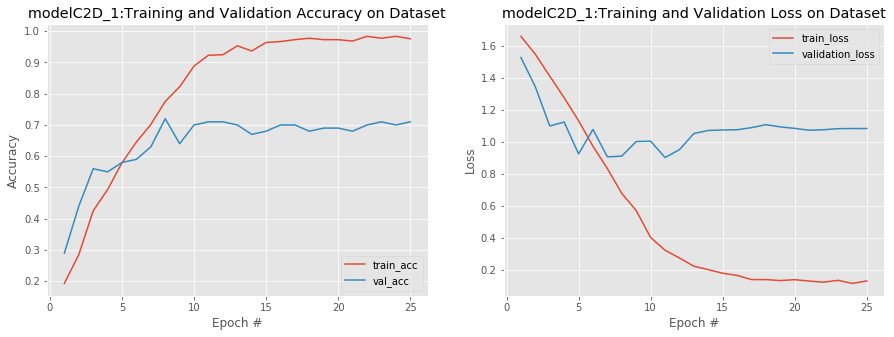

In [15]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure(figsize=(15,5))

# summarize history for Accuracy
plt.subplot(121)
plt.plot(np.arange(1, N+1), H1.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), H1.history["val_categorical_accuracy"], label="val_acc")
plt.title("modelC2D_1:Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# summarize history for loss
plt.subplot(122)
plt.plot(np.arange(1, N+1), H1.history['loss'], label="train_loss")
plt.plot(np.arange(1, N+1), H1.history['val_loss'], label="validation_loss")
plt.title("modelC2D_1:Training and Validation Loss on Dataset")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Model 2: TimeDistributed Conv2d + RNN Model (CNN + RNN) : Increased layers

In [16]:
# Model 2 : Conv2D + RNN with LSTM

# Initial layers take the image nD array as input
modelC2D_2 = Sequential()
# 32 Filters Conv2D layer with Batch Norm
modelC2D_2.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=(10, 120, 120, 3)))
modelC2D_2.add(BatchNormalization())
# 32 Filters Conv2D layer with Batch Norm
modelC2D_2.add(TimeDistributed(Conv2D(32, (3,3), kernel_initializer="he_normal", activation='relu')))
modelC2D_2.add(BatchNormalization())
# Max Pooling Layer
modelC2D_2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 64 Filters Conv2D layer with Batch Norm
modelC2D_2.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
modelC2D_2.add(BatchNormalization())
# 64 Filters Conv2D layer with Batch Norm
modelC2D_2.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
modelC2D_2.add(BatchNormalization())
# Max Pooling Layer
modelC2D_2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 128 Filters Conv2D layer with Batch Norm
modelC2D_2.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
modelC2D_2.add(BatchNormalization())
# 128 Filters Conv2D layer with Batch Norm
modelC2D_2.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
modelC2D_2.add(BatchNormalization())
# Max Pooling Layer
modelC2D_2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# Flatten the feature map into Vector
modelC2D_2.add(TimeDistributed(Flatten()))

# Add a fully connected layer with 50% connections dropped out
modelC2D_2.add(TimeDistributed(Dense(64, activation='relu')))
modelC2D_2.add(Dropout(0.5))

# Add second fully connected layer with 50% connections dropped out
modelC2D_2.add(TimeDistributed(Dense(128, activation='relu')))
modelC2D_2.add(Dropout(0.5))

# Add a LSTM layer
modelC2D_2.add(LSTM(256, return_sequences=False, dropout=0.5))

# Softmax layer for final 5-class output
modelC2D_2.add(Dense(5, activation='softmax'))
modelC2D_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 10, 60, 60, 32)    4736      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 29, 29, 64)    18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 29, 29, 64)    256       
__________

In [17]:
optimiser = Adam(lr = 0.0001) #write your optimizer
modelC2D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelC2D_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 10, 60, 60, 32)    4736      
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 58, 58, 32)    9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 10, 29, 29, 64)    18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 29, 29, 64)    256       
__________

In [18]:
H2 = modelC2D_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
45/45 [==============================] - 23s 502ms/step - loss: 1.6579 - categorical_accuracy: 0.2371 - val_loss: 1.4669 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-03-0819_30_13.737684/model-00001-1.64995-0.24133-1.46685-0.37000.h5
Epoch 2/25
45/45 [==============================] - 18s 410ms/step - loss: 1.5113 - categorical_accuracy: 0.3172 - val_loss: 1.2766 - val_categorical_accuracy: 0.4600

Epoch 00002: saving model to model_init_2020-03-0819_30_13.737684/model-00002-1.51031-0.32278-1.27662-0.46000.h5
Epoch 3/25
45/45 [==============================] - 20s 451ms/step - loss: 1.3726 - categorical_accuracy: 0.4223 - val_loss: 1.2416 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2020-03-0819_30_13.737684/model-00003-1.37162-0.42383-1.24165-0.55000.h5
Epoch 4/25
45/45 [==============================] - 20s 443ms/step - loss: 1.2210 - categorical_accuracy: 0.5199 - val_loss: 1.2180 - val_categorical_accurac

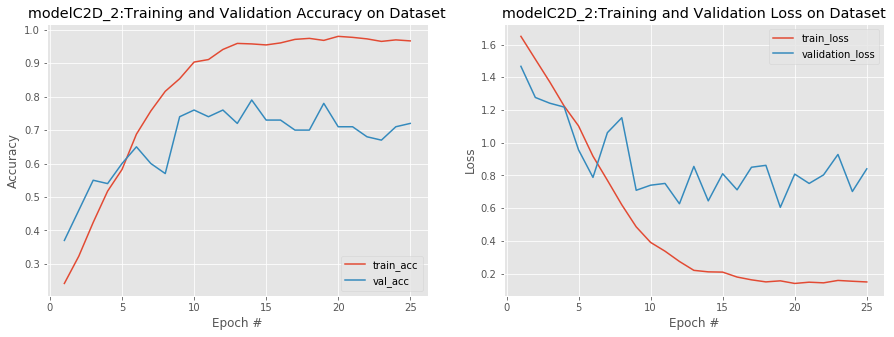

In [19]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure(figsize=(15,5))

# summarize history for Accuracy
plt.subplot(121)
plt.plot(np.arange(1, N+1), H2.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), H2.history["val_categorical_accuracy"], label="val_acc")
plt.title("modelC2D_2:Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# summarize history for loss
plt.subplot(122)
plt.plot(np.arange(1, N+1), H2.history['loss'], label="train_loss")
plt.plot(np.arange(1, N+1), H2.history['val_loss'], label="validation_loss")
plt.title("modelC2D_2:Training and Validation Loss on Dataset")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Model 3: TimeDistributed Conv2d + RNN Model (CNN + RNN) : Reduced Filter size, same no. of layers

In [20]:
# Model 3 : Conv2D + RNN with LSTM

# Initial layers take the image nD array as input
modelC2D_3 = Sequential()
# 16 Filters Conv2D layer with Batch Norm
modelC2D_3.add(TimeDistributed(Conv2D(16, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=(10, 120, 120, 3)))
modelC2D_3.add(BatchNormalization())
# 16 Filters Conv2D layer with Batch Norm
modelC2D_3.add(TimeDistributed(Conv2D(16, (3,3), kernel_initializer="he_normal", activation='relu')))
modelC2D_3.add(BatchNormalization())
# Max Pooling Layer
modelC2D_3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 32 Filters Conv2D layer with Batch Norm
modelC2D_3.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
modelC2D_3.add(BatchNormalization())
# 32 Filters Conv2D layer with Batch Norm
modelC2D_3.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
modelC2D_3.add(BatchNormalization())
# Max Pooling Layer
modelC2D_3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 64 Filters Conv2D layer with Batch Norm
modelC2D_3.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
modelC2D_3.add(BatchNormalization())
# 64 Filters Conv2D layer with Batch Norm
modelC2D_3.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
modelC2D_3.add(BatchNormalization())
# Max Pooling Layer
modelC2D_3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# Flatten the feature map into Vector
modelC2D_3.add(TimeDistributed(Flatten()))

# Add a fully connected layer with 50% connections dropped out
modelC2D_3.add(TimeDistributed(Dense(64, activation='relu')))
modelC2D_3.add(Dropout(0.5))

# Add second fully connected layer with 50% connections dropped out
modelC2D_3.add(TimeDistributed(Dense(128, activation='relu')))
modelC2D_3.add(Dropout(0.5))

# Add a LSTM layer
modelC2D_3.add(LSTM(256, return_sequences=False, dropout=0.5))

# Softmax layer for final 5-class output
modelC2D_3.add(Dense(5, activation='softmax'))
modelC2D_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 10, 60, 60, 16)    2368      
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_23 (TimeDis (None, 10, 58, 58, 16)    2320      
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 58, 58, 16)    64        
_________________________________________________________________
time_distributed_24 (TimeDis (None, 10, 29, 29, 16)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 10, 29, 29, 32)    4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 29, 29, 32)    128       
__________

In [21]:
optimiser = Adam(lr = 0.0001) #write your optimizer
modelC2D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelC2D_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 10, 60, 60, 16)    2368      
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_23 (TimeDis (None, 10, 58, 58, 16)    2320      
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 58, 58, 16)    64        
_________________________________________________________________
time_distributed_24 (TimeDis (None, 10, 29, 29, 16)    0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 10, 29, 29, 32)    4640      
_________________________________________________________________
batch_normalization_13 (Batc (None, 10, 29, 29, 32)    128       
__________

In [22]:
H3 = modelC2D_3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
45/45 [==============================] - 22s 490ms/step - loss: 1.6597 - categorical_accuracy: 0.2266 - val_loss: 1.5029 - val_categorical_accuracy: 0.3900

Epoch 00001: saving model to model_init_2020-03-0819_30_13.737684/model-00001-1.65925-0.22474-1.50293-0.39000.h5
Epoch 2/25
45/45 [==============================] - 17s 375ms/step - loss: 1.5603 - categorical_accuracy: 0.2844 - val_loss: 1.4611 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2020-03-0819_30_13.737684/model-00002-1.56152-0.28356-1.46106-0.45000.h5
Epoch 3/25
45/45 [==============================] - 19s 430ms/step - loss: 1.4809 - categorical_accuracy: 0.3763 - val_loss: 1.3323 - val_categorical_accuracy: 0.4200

Epoch 00003: saving model to model_init_2020-03-0819_30_13.737684/model-00003-1.48204-0.37707-1.33234-0.42000.h5
Epoch 4/25
45/45 [==============================] - 19s 432ms/step - loss: 1.3647 - categorical_accuracy: 0.4415 - val_loss: 1.1582 - val_categorical_accurac

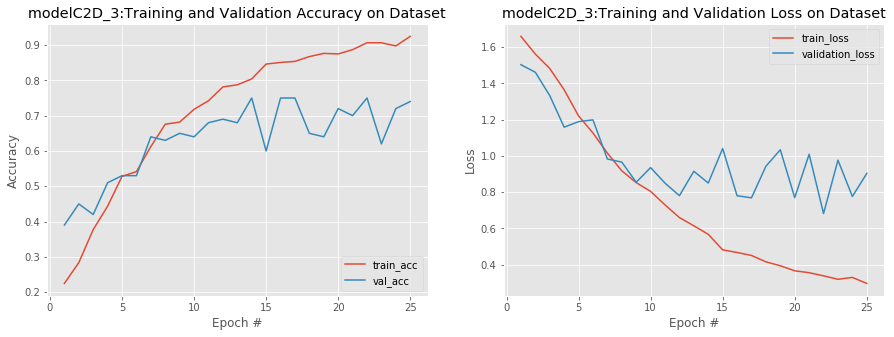

In [23]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure(figsize=(15,5))

# summarize history for Accuracy
plt.subplot(121)
plt.plot(np.arange(1, N+1), H3.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), H3.history["val_categorical_accuracy"], label="val_acc")
plt.title("modelC2D_3:Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# summarize history for loss
plt.subplot(122)
plt.plot(np.arange(1, N+1), H3.history['loss'], label="train_loss")
plt.plot(np.arange(1, N+1), H3.history['val_loss'], label="validation_loss")
plt.title("modelC2D_3:Training and Validation Loss on Dataset")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Model 4: TimeDistributed Conv2d + RNN Model (CNN + RNN) : Reduced Filter size, reduced layers

In [24]:
# Model 4 : Conv2D + RNN with LSTM

# Initial layers take the image nD array as input
modelC2D_4 = Sequential()
# 16 Filters Conv2D layer with Batch Norm
modelC2D_4.add(TimeDistributed(Conv2D(16, (7, 7), strides=(2, 2), activation='relu', padding='same'), input_shape=(10, 120, 120, 3)))
modelC2D_4.add(BatchNormalization())
# 16 Filters Conv2D layer with Batch Norm
modelC2D_4.add(TimeDistributed(Conv2D(16, (3,3), kernel_initializer="he_normal", activation='relu')))
modelC2D_4.add(BatchNormalization())
# Max Pooling Layer
modelC2D_4.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# 32 Filters Conv2D layer with Batch Norm
modelC2D_4.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
modelC2D_4.add(BatchNormalization())
# 32 Filters Conv2D layer with Batch Norm
modelC2D_4.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
modelC2D_4.add(BatchNormalization())
# Max Pooling Layer
modelC2D_4.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

# Flatten the feature map into Vector
modelC2D_4.add(TimeDistributed(Flatten()))

# Add a fully connected layer with 50% connections dropped out
modelC2D_4.add(TimeDistributed(Dense(64, activation='relu')))
modelC2D_4.add(Dropout(0.5))

# Add second fully connected layer with 50% connections dropped out
modelC2D_4.add(TimeDistributed(Dense(128, activation='relu')))
modelC2D_4.add(Dropout(0.5))

# Add a LSTM layer
modelC2D_4.add(LSTM(256, return_sequences=False, dropout=0.5))

# Softmax layer for final 5-class output
modelC2D_4.add(Dense(5, activation='softmax'))
modelC2D_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 10, 60, 60, 16)    2368      
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 10, 58, 58, 16)    2320      
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 58, 58, 16)    64        
_________________________________________________________________
time_distributed_36 (TimeDis (None, 10, 29, 29, 16)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 10, 29, 29, 32)    4640      
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 29, 29, 32)    128       
__________

In [25]:
optimiser = Adam(lr = 0.0001) #write your optimizer
modelC2D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelC2D_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_34 (TimeDis (None, 10, 60, 60, 16)    2368      
_________________________________________________________________
batch_normalization_17 (Batc (None, 10, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_35 (TimeDis (None, 10, 58, 58, 16)    2320      
_________________________________________________________________
batch_normalization_18 (Batc (None, 10, 58, 58, 16)    64        
_________________________________________________________________
time_distributed_36 (TimeDis (None, 10, 29, 29, 16)    0         
_________________________________________________________________
time_distributed_37 (TimeDis (None, 10, 29, 29, 32)    4640      
_________________________________________________________________
batch_normalization_19 (Batc (None, 10, 29, 29, 32)    128       
__________

In [26]:
H4 = modelC2D_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
45/45 [==============================] - 22s 485ms/step - loss: 1.6288 - categorical_accuracy: 0.2265 - val_loss: 1.5332 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-03-0819_30_13.737684/model-00001-1.63330-0.21870-1.53320-0.35000.h5
Epoch 2/25
45/45 [==============================] - 17s 372ms/step - loss: 1.5795 - categorical_accuracy: 0.2623 - val_loss: 1.3845 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to model_init_2020-03-0819_30_13.737684/model-00002-1.57773-0.26697-1.38454-0.48000.h5
Epoch 3/25
45/45 [==============================] - 19s 431ms/step - loss: 1.4679 - categorical_accuracy: 0.3689 - val_loss: 1.3211 - val_categorical_accuracy: 0.5200

Epoch 00003: saving model to model_init_2020-03-0819_30_13.737684/model-00003-1.46785-0.36953-1.32107-0.52000.h5
Epoch 4/25
45/45 [==============================] - 19s 425ms/step - loss: 1.3588 - categorical_accuracy: 0.4209 - val_loss: 1.5195 - val_categorical_accurac

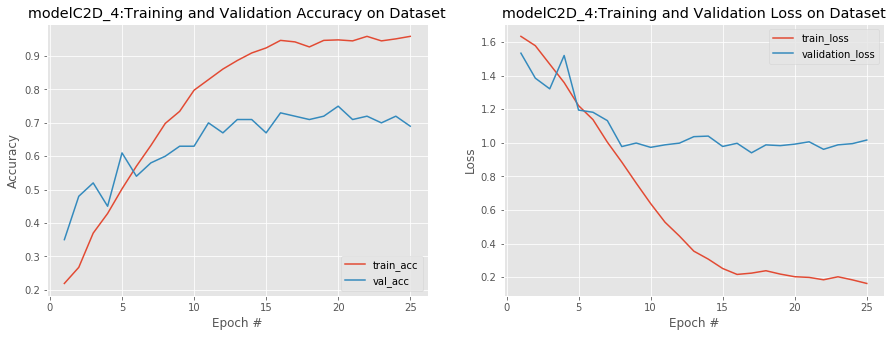

In [27]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure(figsize=(15,5))

# summarize history for Accuracy
plt.subplot(121)
plt.plot(np.arange(1, N+1), H4.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), H4.history["val_categorical_accuracy"], label="val_acc")
plt.title("modelC2D_4:Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# summarize history for loss
plt.subplot(122)
plt.plot(np.arange(1, N+1), H4.history['loss'], label="train_loss")
plt.plot(np.arange(1, N+1), H4.history['val_loss'], label="validation_loss")
plt.title("modelC2D_4:Training and Validation Loss on Dataset")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

### Model 5: Conv3D Model

In [28]:
# Model 5: Conv3d with 3-Conv layers + 2 Fully Connected

modelC3D_1 = Sequential()

# Initial layers take the image nD array as input
# 8 Filters Conv3D layer with Batch Norm
modelC3D_1.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(10, 120, 120, 3), padding='same'))
modelC3D_1.add(BatchNormalization())
modelC3D_1.add(Activation('relu'))

modelC3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

# 16 Filters Conv3D layer with Batch Norm
modelC3D_1.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
modelC3D_1.add(BatchNormalization())
modelC3D_1.add(Activation('relu'))
# Max Pooling Layer
modelC3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

# 32 Filters Conv2D layer with Batch Norm
modelC3D_1.add(Conv3D(32, kernel_size=(1,3,3), padding='same'))
modelC3D_1.add(BatchNormalization())
modelC3D_1.add(Activation('relu'))
# Max Pooling Layer
modelC3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten the feature map into Vector
modelC3D_1.add(Flatten())

# Add a fully connected layer with 25% connections dropped out
modelC3D_1.add(Dense(256, activation='relu'))
modelC3D_1.add(Dropout(0.25))

# Add second fully connected layer with 25% connections dropped out
modelC3D_1.add(Dense(512, activation='relu'))
modelC3D_1.add(Dropout(0.25))

# Softmax layer for final 5-class output
modelC3D_1.add(Dense(5, activation='softmax'))

modelC3D_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 10, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_22 (Batc (None, 5, 60, 60, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 5, 60, 60, 16)     0         
__________

In [30]:
optimiser = Adam() #write your optimizer
modelC3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelC3D_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 10, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 60, 60, 16)     3472      
_________________________________________________________________
batch_normalization_22 (Batc (None, 5, 60, 60, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 5, 60, 60, 16)     0         
__________

In [31]:
H5 = modelC3D_1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
45/45 [==============================] - 21s 470ms/step - loss: 4.3797 - categorical_accuracy: 0.3111 - val_loss: 6.2599 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-03-0819_30_13.737684/model-00001-4.41033-0.31071-6.25991-0.24000.h5
Epoch 2/25
45/45 [==============================] - 17s 382ms/step - loss: 1.2645 - categorical_accuracy: 0.4725 - val_loss: 1.4469 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-03-0819_30_13.737684/model-00002-1.27342-0.46908-1.44689-0.44000.h5
Epoch 3/25
45/45 [==============================] - 20s 438ms/step - loss: 1.1615 - categorical_accuracy: 0.5187 - val_loss: 1.7559 - val_categorical_accuracy: 0.3900

Epoch 00003: saving model to model_init_2020-03-0819_30_13.737684/model-00003-1.14739-0.52790-1.75590-0.39000.h5
Epoch 4/25
45/45 [==============================] - 19s 427ms/step - loss: 0.9778 - categorical_accuracy: 0.6000 - val_loss: 1.1367 - val_categorical_accurac

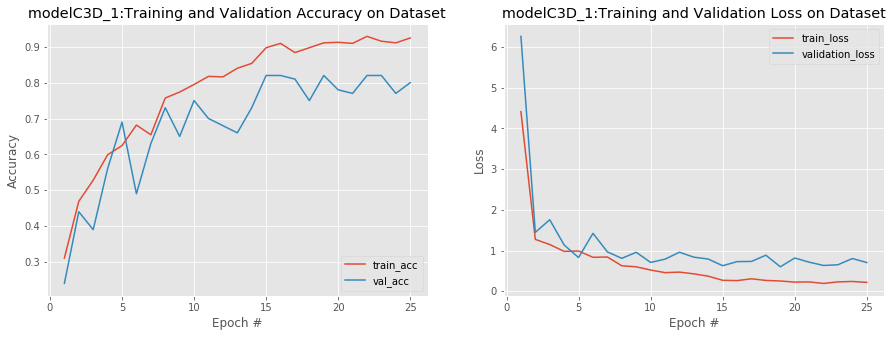

In [32]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure(figsize=(15,5))

# summarize history for Accuracy
plt.subplot(121)
plt.plot(np.arange(1, N+1), H5.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), H5.history["val_categorical_accuracy"], label="val_acc")
plt.title("modelC3D_1:Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# summarize history for loss
plt.subplot(122)
plt.plot(np.arange(1, N+1), H5.history['loss'], label="train_loss")
plt.plot(np.arange(1, N+1), H5.history['val_loss'], label="validation_loss")
plt.title("modelC3D_1:Training and Validation Loss on Dataset")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## Conclusion

## <font color = blue> A total of 5 different models have been tried, 4 CNN+RNN (Conv2D + LSTM)  & 1 Conv3D </font>
### Below is the best performance accuracy achieved by each of these model at different epochs

#### <font color = blue> 1. Model 1 : Conv2D + RNN with LSTM with 2 groups of 32 filters & 64 filters followed by two fully connected, LSTM & Softmax </font>
##### This model has 1,276,901 trainable parameters. It achieved best performance at epoch 25
##### Training Accuracy: 97.63% against Validation Accuracy of 71%. Training loss: 0.1297 & Validation Loss: 1.0842

#### <font color = blue> 2. Model 2 : Conv2D + RNN with LSTM with 3 groups of 32 , 64 & 128 filters followed by two fully connected, LSTM & Softmax </font>
##### This model has 1,097,957 trainable parameters. It achieved best performance at epoch 14
##### Training Accuracy: 95.85% against Validation Accuracy of 79%. Training loss: 0.2101 & Validation Loss: 0.6449

#### <font color = blue> 3. Model 3 : Conv2D + RNN with LSTM with 3 groups of 16, 32 & 64 filters followed by two fully connected, LSTM & Softmax </font>
##### This model has 679,509 trainable parameters. It achieved best performance at epoch 22
##### Training Accuracy: 90.81% against Validation Accuracy of 75%. Training loss: 0.3336 & Validation Loss: 0.6816

#### <font color = blue> 4. Model 4 : Conv2D + RNN with LSTM with 2 groups of 16 & 32 filters followed by two fully connected, LSTM & Softmax </font>
##### This model has 824,277 trainable parameters. It achieved best performance at epoch 20
##### Training Accuracy: 94.96% against Validation Accuracy of 75%. Training loss: 0.2029 & Validation Loss: 0.9921

#### <font color = blue> 5. Model 5 : Conv3D with 2 layers of 8, 16 & 32 filters followed by two fully connected with dropouts & Softmax </font>
##### This model has 1,986,597 trainable parameters. It achieved best performance at epoch 15
##### Training Accuracy: 89.34% against Validation Accuracy of 82%. Training loss: 0.2716 & Validation Loss: 0.6270

### Considering the crucial factor of significant validation accuracy with least difference between the Validation & Training Accuracy (so as to avoid overfitting), Model # 5 i.e. the Conv3D model at epoch 15 has given the best result of the lot. So, we will be considering the file <font color=blue> "model-00015-0.26885-0.89744-0.62697-0.82000.h5" </font>  generated as a part of this epoch for the test validations as well. Although this Model # 5 has higher parameter count, but because of its more accurate results with considerably less loss values, we consider it as the best fit of all the models.